# Projet 5 :Segmentez des clients d'un site e-commerce


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
# folium
import seaborn as sns
import numpy as np
import pickle

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')
sns.set()

In [2]:
file_path = '/Users/admin/Desktop/formation_data_Scientist/projet5/Donnees/'

In [3]:
data_customers = pd.read_csv(file_path + 'data_customers')

In [4]:
data_order_purchase_timestamp = data_customers[['customer_unique_id', 'order_purchase_timestamp']]

In [5]:
data_rfm = pd.read_csv(file_path + 'data_rfm')

In [6]:
data_rfm

,customer_unique_id,price_mean,frequency,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,1,116.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,1,119.0
2,0000f46a3911fa3c0805444483337064,69.00,1,542.0
3,0000f6ccb0745a6a4b88665a16c9f078,25.99,1,326.0
4,0004aac84e0df4da2b147fca70cf8255,180.00,1,293.0
...,...,...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,785.00,2,452.0
96092,fffea47cd6d3cc0a88bd621562a9d061,64.89,1,267.0
96093,ffff371b4d645b6ecea244b27531430a,89.90,1,573.0
96094,ffff5962728ec6157033ef9805bacc48,115.00,1,124.0


### Ajout de la variable order_purchase_timestamp au dataset RFM

In [7]:
data_rfm = pd.merge(data_rfm, data_order_purchase_timestamp,
                    how="left",
                    on='customer_unique_id')

In [13]:
data_rfm

,customer_unique_id,price_mean,frequency,recency,order_purchase_timestamp
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,1,116.0,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,1,119.0,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,69.00,1,542.0,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,25.99,1,326.0,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,180.00,1,293.0,2017-11-14 19:45:42
...,...,...,...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,785.00,2,452.0,2017-06-08 21:00:36
96092,fffea47cd6d3cc0a88bd621562a9d061,64.89,1,267.0,2017-12-10 20:07:56
96093,ffff371b4d645b6ecea244b27531430a,89.90,1,573.0,2017-02-07 15:49:16
96094,ffff5962728ec6157033ef9805bacc48,115.00,1,124.0,2018-05-02 15:17:41


In [14]:
data_customers_reduce = data_customers.sample(10000, random_state=1).copy().drop(['customer_city','customer_state', 'customer_unique_id', 'order_purchase_timestamp'], axis = 1)

In [15]:
data_rfm_reduce = data_rfm.sample(10000, random_state=1).copy().drop(['customer_unique_id', 'order_purchase_timestamp'], axis = 1)

In [16]:
data_rfm_reduce

,price_mean,frequency,recency
44461,55.00,1,123.0
40668,10.00,1,105.0
72101,29.99,1,565.0
73856,159.90,1,231.0
17996,12.99,1,12.0
...,...,...,...
52480,24.50,1,301.0
30344,45.49,1,261.0
24637,159.90,2,284.0
78834,35.00,1,85.0


In [17]:
data_rfm_reduce.dtypes

price_mean    float64
frequency       int64
recency       float64
dtype: object

### Normalisation des données

In [18]:
def preprocessing(df):
    X = df.copy()

    categorical_columns = X.select_dtypes(['category','object']).columns
    numerical_columns = X.select_dtypes(['int64','float64']).columns

    ohe = OneHotEncoder(sparse=False)
    ss = StandardScaler()
    X[numerical_columns] = ss.fit_transform(X[numerical_columns])
    ohe.fit(X[categorical_columns])

    X = pd.merge(X[numerical_columns], 
          pd.DataFrame(columns = ohe.get_feature_names().tolist(),
              data = ohe.fit_transform(X[categorical_columns])).set_index(X.index),
        left_index = True, right_index = True)
    X = X.dropna()
    return X


In [19]:
X = preprocessing(data_customers_reduce)

In [20]:
X_RFM = preprocessing(data_rfm_reduce)

In [21]:
X_RFM

,price_mean,frequency,recency
44461,-0.383635,-0.290070,-0.790220
40668,-0.628397,-0.290070,-0.907558
72101,-0.519668,-0.290070,2.091062
73856,0.186934,-0.290070,-0.086197
17996,-0.612134,-0.290070,-1.513800
...,...,...,...
52480,-0.549529,-0.290070,0.370115
30344,-0.435361,-0.290070,0.109366
24637,0.186934,1.375084,0.259297
78834,-0.492418,-0.290070,-1.037932


 ### Recherche de corrélation entre les varibales du dataset client : méthode ACP

In [22]:
#Affichage de la variance expliquée en fonction du nombre de variable
def ACP(X):
    #print('Variance expliquée')
    pca = PCA(random_state=0)
    pca.fit_transform(X)
    ratio_lambda = np.cumsum(pca.explained_variance_ratio_)
    plt.figure(figsize=(10,4))
    plt.title('Somme cumulée de variance des composantes de l\'ACP')
    plt.xlabel('Nombre de composantes de l\'ACP')
    plt.ylabel('Variance cumulée')
    plt.plot(list(range(X.shape[1])), ratio_lambda)

#variance expliquée
    ratio_lambda = np.cumsum(pca.explained_variance_ratio_)

#Affichage du nombre de variable à garder , ie ont une varince cumulés inférieur à .9
    liste_X = []
    liste_Y = []
    ymax = 0.9
    for i, j in zip(list(range(X.shape[1])), ratio_lambda):
        if j >= ymax:
            liste_X.append(i)
            liste_Y.append(j)
    print('le nombre de variable à conserver est:', liste_X[0])

#Point sur la courbe de variance cumulés qui sépare le nombre de vaibale à garder de celles à supprimer 
    plt.plot(liste_X[0],liste_Y[0], marker="o", color="red")
    plt.axvline(x = liste_X[0], ymax=liste_Y[0], color = 'r', ls='--')
    plt.axhline(y = liste_Y[0], xmax = liste_X[0], color = 'r', ls='--')
    plt.show()

# Cercle de corrélation'''

    print('Cercle de corrélation')

    colonnes_pca = X.columns
    from matplotlib.patches import Circle
    sns.set_context("paper", font_scale=1) 
    plt.figure(figsize=(10,10))
    chaine = "Plan factoriel pour les 2 premières composantes de l'ACP"
    plt.title(chaine)
    plt.xlabel('Composante 1')
    plt.ylabel('Composante 2')
    ax = plt.gca()
    ax.add_patch(Circle([0,0], radius=1, color='black', fill=False, linestyle='-', 
                    clip_on=False))
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    x_pca = pca.components_[0,:]
    y_pca = pca.components_[1,:]

    sns.scatterplot(x = x_pca,
                y = y_pca,
               alpha = 0.5)
    plt.plot([-1,1],[0,0], color='grey', alpha=0.8)
    plt.plot([0,0],[-1,1], color='grey', alpha=0.8)

    i = 0
    for x,y,colonne in zip(x_pca,y_pca, colonnes_pca):

        plt.annotate(colonne, 
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(0,5+np.random.randint(-10,10)),
                 ha='center') 
        ax.arrow(0, 0, x, y, head_width=0, head_length=0, fc='grey', ec='grey',
             alpha=0.2)

    
    sns.set_context("paper", font_scale=1) 


le nombre de variable à conserver est: 10


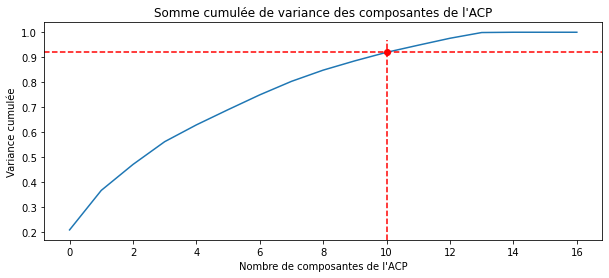

Cercle de corrélation


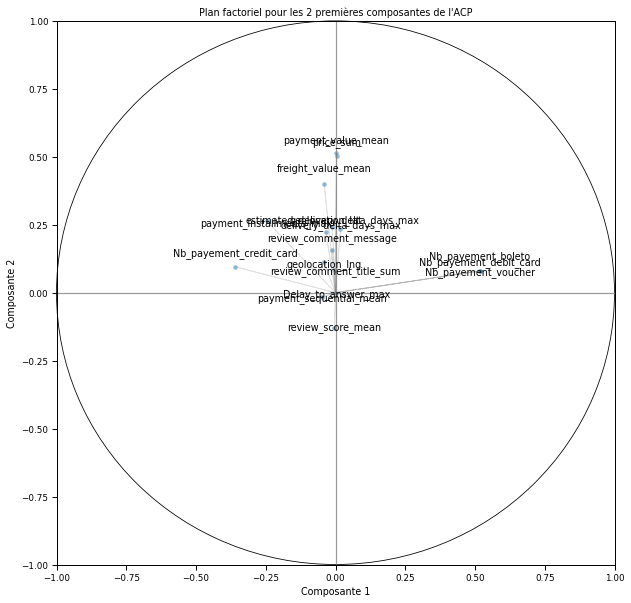

In [23]:
ACP(X = X)

La réduction dimmensionnelle va se faire en choisisant 95% de la variance ce qui permet de réduire de 12 le nombre de dimmensions

In [19]:
X.drop(['Nb_payement_boleto', 'Nb_payement_voucher', 'price_sum', 'delivery_delta_days_max',
       'geolocation_lng', 'review_comment_message', 'review_comment_title_sum', 'Delay_to_answer_max',
       'payment_sequential_mean', 'review_score_mean', 'geolocation_lat', 'estimated_delivery_delta_days_max', 'payment_installments_max'], axis = 1, inplace =True)

In [20]:
X = preprocessing(X)

In [21]:
X

,Nb_payement_credit_card,Nb_payement_debit_card,freight_value_mean,payment_value_mean
44461,0.132203,-0.436355,0.176449,-0.361140
40668,0.132203,-0.436355,-0.758671,-0.636147
72101,-1.240282,-0.436355,-0.346847,-0.616082
73856,-1.240282,1.381569,-0.347466,0.080151
17996,0.132203,-0.436355,-0.788397,-0.624661
...,...,...,...,...
52480,0.132203,-0.436355,-0.512196,-0.551586
30344,-1.240282,1.381569,-0.630479,-0.464279
24637,1.504689,-0.436355,0.177687,0.955824
78834,0.132203,-0.436355,-0.696124,-0.517130


## Recherche d'un optimum du nombre de clusters 

### Dataset RFM

In [22]:
import warnings
warnings.filterwarnings('ignore')

Trial_nb 1
nombre de centre mobile choisi est: 1
nombre de centre mobile choisi est: 2
nombre de centre mobile choisi est: 3
nombre de centre mobile choisi est: 4
nombre de centre mobile choisi est: 5
nombre de centre mobile choisi est: 6
nombre de centre mobile choisi est: 7
nombre de centre mobile choisi est: 8


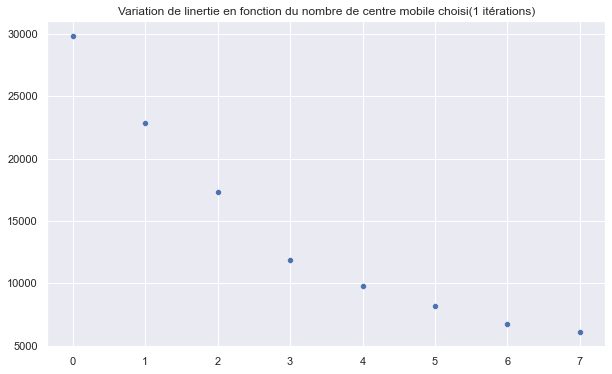

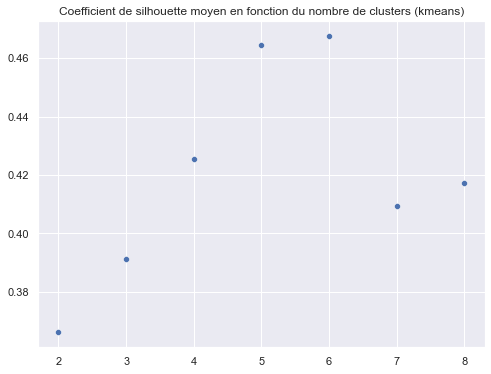

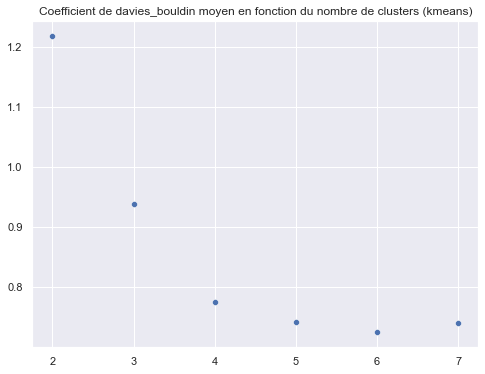

In [27]:
def kmeans_somme_inertie(df, Trial_nb, max_clusters):  
    dict_kmeans = {}
    inertia = []
    for nb in range(1, Trial_nb + 1):
        print('Trial_nb', nb)
        for n_clusters in range(1, max_clusters+1):
            print('nombre de centre mobile choisi est:', n_clusters)
            kmeans = KMeans(n_clusters=n_clusters,
                       verbose=0,
                       n_jobs=1).fit(df)
            inertia.append(kmeans.inertia_)
            dict_kmeans[nb,n_clusters] = kmeans
    return inertia, dict_kmeans

''' La fonction suivant permettant la détermination du  coefficient de silhouette 
    ainsi que  l'indice de Davies-Bouldin pour chaque nombre de cluster choisi'''

def silhouettes(df, Trial_nb = 1, max_clusters = 8): 
        inertia, dict_kmeans = kmeans_somme_inertie(df = df, Trial_nb = 1, max_clusters = 8)
        davies_bouldin_kmeans = {}
        silhouettes_kmeans = {}
        
        #Détermination du coefficient de silhouttes
        for n_clusters in range(2, max_clusters+1):
            silhouettes_kmeans[n_clusters] = silhouette_score(X = df,
                                             labels= list(dict_kmeans[(1,n_clusters)].labels_))
            
         #Détermination de l'indice de Davies-Bouldin  
        for n_clusters in range(2, max_clusters):
            davies_bouldin_kmeans[n_clusters] = davies_bouldin_score(X = df,
                                             labels= list(dict_kmeans[(1,n_clusters)].labels_))
        
        #plot du coefficient de silhouette ainsi que l'indice de Davies-Bouldin en 
        #fonction du nombre de clusters choisi
        plt.figure(figsize=(10,6))
        lol = lambda inertia, sz: [inertia[i:i+sz] for i in range(0, len(inertia), sz)]
        plt.title('Variation de linertie en fonction du nombre de centre mobile choisi(' + str(Trial_nb) + ' itérations)')
    
        for iteration in range(0, Trial_nb):
            sns.scatterplot(list(range(0,max_clusters)),
                     lol(inertia, max_clusters)[iteration])
        plt.figure(figsize=(8,6)),
        plt.title('Coefficient de silhouette moyen en fonction du nombre de clusters (kmeans)')
        sns.scatterplot(x = list(silhouettes_kmeans.keys()),
               y = list(silhouettes_kmeans.values()))
        
        plt.figure(figsize=(8,6)),
        plt.title('Coefficient de davies_bouldin moyen en fonction du nombre de clusters (kmeans)')
        sns.scatterplot(x = list(davies_bouldin_kmeans.keys()),
               y = list(davies_bouldin_kmeans.values()))
X_RFM = preprocessing(data_rfm_reduce)
silhouettes(df = X_RFM, Trial_nb = 1, max_clusters = 8)


### Segmentation du dataset RFM

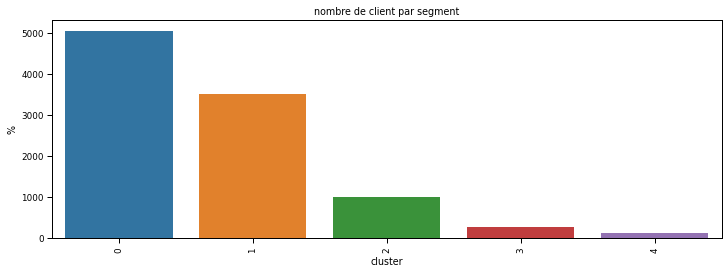

<Figure size 864x288 with 0 Axes>

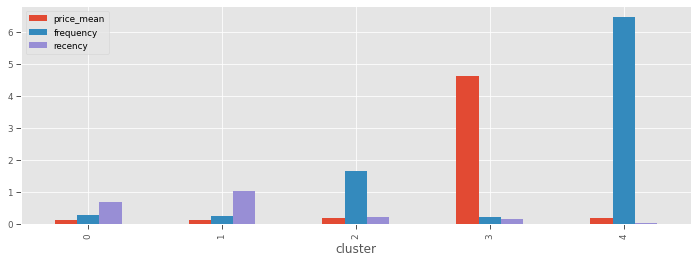

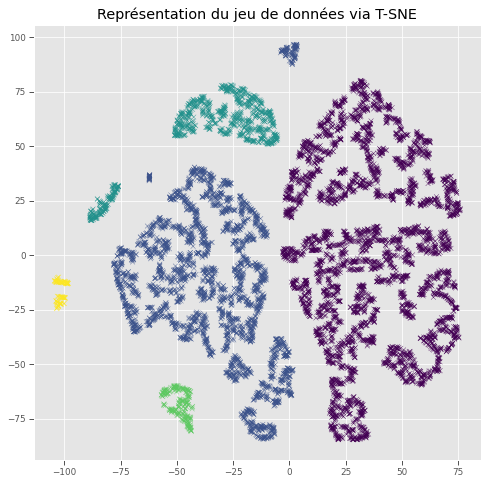

<Figure size 864x288 with 0 Axes>

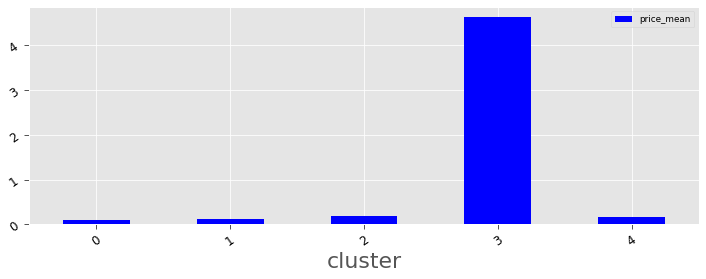

<Figure size 864x288 with 0 Axes>

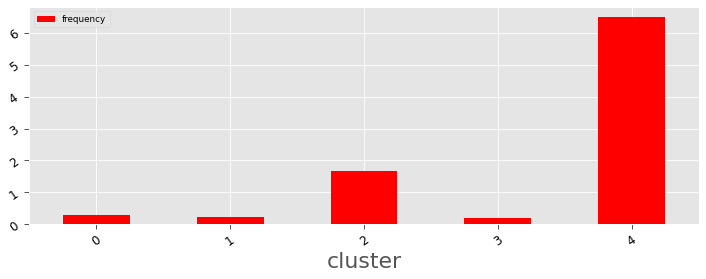

<Figure size 864x288 with 0 Axes>

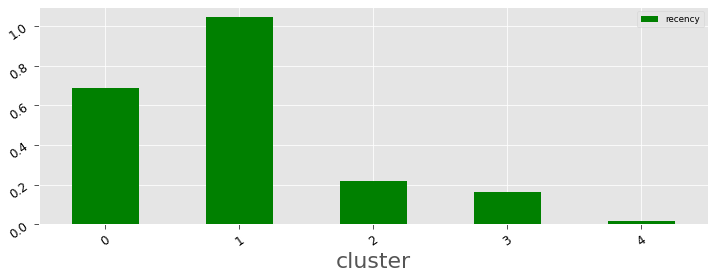

,price_mean,frequency,recency,cluster
44461,-0.383635,-0.290070,-0.790220,0
40668,-0.628397,-0.290070,-0.907558,0
72101,-0.519668,-0.290070,2.091062,1
73856,0.186934,-0.290070,-0.086197,0
17996,-0.612134,-0.290070,-1.513800,0
...,...,...,...,...
52480,-0.549529,-0.290070,0.370115,1
30344,-0.435361,-0.290070,0.109366,0
24637,0.186934,1.375084,0.259297,2
78834,-0.492418,-0.290070,-1.037932,0


In [25]:
from sklearn.cluster import KMeans
def segmentation_kmeans(df, n_clusters):
    kmeans = KMeans(n_clusters = n_clusters, init = 'k-means++')
    y_kmeans = kmeans.fit_predict(df)

    df['cluster'] = y_kmeans
    
    tsne = TSNE(n_components=2)
    T = tsne.fit_transform(df.copy())

    cluster_count = df.groupby(by='cluster')['cluster'].count()
    cluster_mean = df.groupby(by='cluster').mean()

    plt.figure(figsize=(12,4))
    sns.barplot(x=cluster_count.index, y= cluster_count.values)
    plt.ylabel("%")
    plt.title("nombre de client par segment")
    plt.style.use('ggplot')
    plt.xticks(rotation=90)
    plt.show()

    ax = plt.figure(figsize=(12,4))
    ax = abs(cluster_mean).plot.bar(figsize=(12,4));
    ax.legend()
    plt.show()
    
    
    plt.figure(figsize=(8,8))
    plt.title('Représentation du jeu de données via T-SNE')
    sns.scatterplot(T[:,0], T[:,1],marker='x',
    c=y_kmeans,
    cmap='viridis')
    
    liste = ['price_mean', 'frequency','recency']
    for liste in liste:
        groupe = df[[liste, 'cluster']].groupby(by='cluster').mean()
        ax = plt.figure(figsize=(12,4))
        if liste == 'price_mean':
            c = 'b'
        elif liste == 'frequency':
            c = 'r'
        else:
            c = 'g'
        ax = abs(groupe).plot.bar(figsize=(12,4), color = c);
        plt.xticks(rotation=35, fontsize=12, color='black')
        plt.xlabel("cluster", fontsize=22)
        plt.yticks(rotation=35, fontsize=12, color='black')
        ax.legend()
        plt.show()
    display(df)
    
segmentation_kmeans(df = X_RFM, n_clusters = 5)

In [17]:
from sklearn.metrics import adjusted_rand_score

def stability_init(X, range_n_clusters, n_iters=10):
    """
    Calcul de la stabilité à l'initialisation avec
    la métrique ARI

    paramètres
    X: data à passer dans l'algo de clustering
    range_n_clusters: list du nombre de clusters
    n_iters: nombre de fois que le clustering est effectué
    """

    ARI = {}
    ARI_mean, ARI_std = {}, {}
    rfm_table = pd.DataFrame()
    for n_clusters in range(2, range_n_clusters):
        data_rfm1 = data_rfm_reduce.copy().select_dtypes(include=['int64', 'float64'])
        data_rfm1 = preprocessing(data_rfm1)
        kmeans = KMeans(n_clusters=4,
                        init='k-means++',
                        random_state=100)
        kmeans = KMeans(n_clusters=n_clusters,
                        init='k-means++',
                        random_state=100)

        clusters = kmeans.fit_predict(X)
        rfm_table['n_clusters_' + str(n_clusters)] = clusters
        ARI[n_clusters] = []

        for n_it in range(n_iters):
            km = KMeans(n_clusters=n_clusters,
                        init='k-means++',
                        random_state=n_it)
            clusters = km.fit_predict(X)
            ARI[n_clusters].append(
                adjusted_rand_score(rfm_table['n_clusters_' + str(n_clusters)],
                                    clusters))
        ARI_mean[n_clusters] = np.mean(ARI[n_clusters])
    return ARI_mean
ARI_mean = stability_init(X = X_RFM, range_n_clusters = 20, n_iters=3)

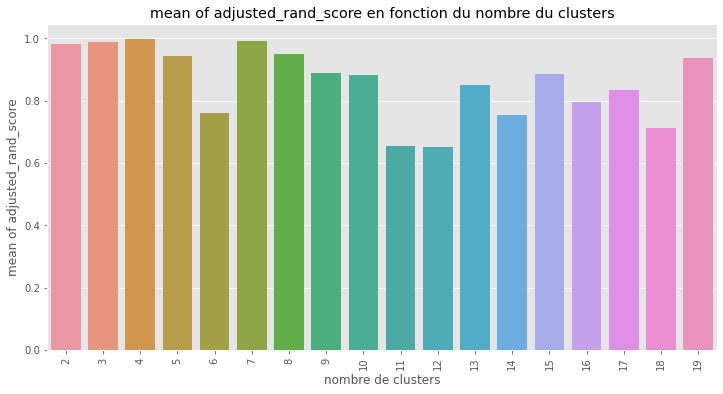

In [22]:
# Affiche de la variation de la moyenne de ARI en fonction du nombre de clusters
fig = plt.figure(figsize=(12, 6))
sns.barplot(x=list(ARI_mean.keys()), y=list(ARI_mean.values()))
plt.ylabel("mean of adjusted_rand_score")
plt.xlabel("nombre de clusters")
plt.title("mean of adjusted_rand_score en fonction du nombre du clusters")
plt.style.use('ggplot')
plt.xticks(rotation=90)
plt.show()

### RFM_Plus: Ajout de quelques variables au datasetRFM

In [18]:
def rfm_plus(data1, data2):
    cols_to_add = data1[['Nb_payement_credit_card', 'Delay_to_answer_max', 'customer_unique_id']]
    data_rfm_plus = pd.merge(data2, cols_to_add,
                    how="left",
                    on='customer_unique_id')
    data_rfm_plus =  data_rfm_plus.sample(10000, random_state=1).copy().drop('customer_unique_id', axis = 1)
    numerics = ['int64', 'float64']

    X_rfm_plus = data_rfm_plus.select_dtypes(include=numerics)
    X_rfm_plus = preprocessing(X_rfm_plus)
    return X_rfm_plus
X_rfm_plus = rfm_plus(data1 = data_customers, data2 = data_rfm)


#### Recherche de corrélation entre les variables

In [ ]:
ACP(X = X_rfm_plus)

####  recherche de nombre de cluster Kmeans RFM_plus

In [ ]:
silhouettes(df = X_rfm_plus, Trial_nb = 1, max_clusters = 8)

In [ ]:
segmentation_kmeans(df = X_rfm_plus, n_clusters = 5)

In [19]:
from sklearn.metrics import adjusted_rand_score
import datetime
import dateutil.relativedelta
def data_sample(df, m): 
    df['order_purchase_timestamp'] = df['order_purchase_timestamp'].astype('datetime64')
    df_sample = df.sample(10000, random_state=1).copy().drop(['customer_unique_id'], axis = 1)   
    d = df_sample['order_purchase_timestamp'].max()
    d2 = d - dateutil.relativedelta.relativedelta(months = m)
    data_rfm_reduce = df_sample[df_sample['order_purchase_timestamp'] < d2]
    data_rfm_reduce = data_rfm_reduce.drop('order_purchase_timestamp', axis = 1)
    
    return data_rfm_reduce
    
def data_init(df5, n_clusters):
    df_init = data_sample(df = df5, m = 0)
    df_init = preprocessing(df_init)
    kmeans = KMeans(n_clusters= n_clusters,random_state=1000)
    cluster = kmeans.fit_predict(df_init)
    df_init['cluster'] = cluster
    return df_init


def score_ARI(n_clusters, period):
    table_score = []
    df_init = data_init(df5 = data_rfm, n_clusters = n_clusters)
    #score_AR = []
    score_ARI = []
    for K in range(0, period, 1):
        df_period = data_sample(df = data_rfm, m = K)
        df_period = preprocessing(df_period)
    #display(df_score)
        df_init =  df_init[df_init.index.isin(df_period.index)]
        kmeans = KMeans(n_clusters=n_clusters,
                       init='k-means++',
                        random_state=1000)

        clusters = kmeans.fit_predict(df_period)
        df_period['cluster'] = clusters
        ARI = round(adjusted_rand_score(df_init['cluster'], df_period['cluster']), 2)
        score_ARI.append([K, ARI])
        table_score = pd.DataFrame(score_ARI, columns = ['Month', 'Score'])
        
    return table_score
table_score = score_ARI(n_clusters  = 5, period = 9)    
def plot_score_ARI(table_score):    
    table_score = score_ARI(n_clusters  = 5, period = 9)    
    plt.figure(figsize=(10,6)),
    plt.xlabel("Période (mois)")
    plt.ylabel("Score ARI")
    plt.title("Stabilité temporelle de la segmentation RFM par K-Means",
          fontsize=18,
          color="blue")
    sns.lineplot(x = table_score['Month'],
               y = table_score['Score'])
    plt.axhline(y=table_score.iloc[2][1], linestyle="--", 
            color="magenta",
            xmax=0.27,
            linewidth=1)
    plt.axvline(x=table_score.iloc[2][0], linestyle="--", 
            color="magenta",
            ymax=1.3-(table_score.iloc[2][1]),
            linewidth=1)
    plt.show()
    
    return plt.show()


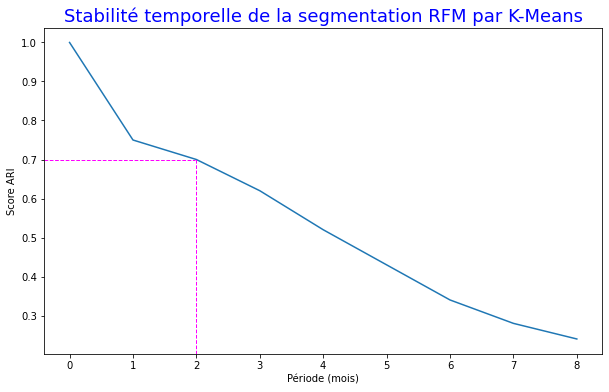

In [20]:
plot_score_ARI(table_score = table_score)

# Kmeans RFM

normailsation des données

# RFM with more feature

le nombre de variable à conserver est: 3


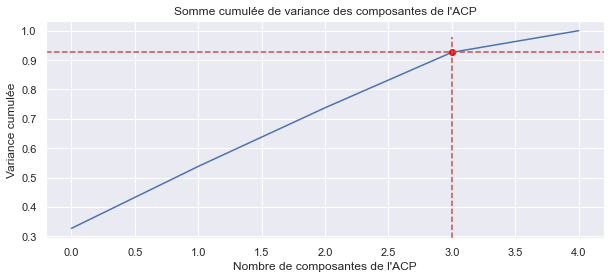

Cercle de corrélation
Trial_nb 1
nombre de centre mobile choisi est: 1
nombre de centre mobile choisi est: 2
nombre de centre mobile choisi est: 3
nombre de centre mobile choisi est: 4
nombre de centre mobile choisi est: 5
nombre de centre mobile choisi est: 6
nombre de centre mobile choisi est: 7
nombre de centre mobile choisi est: 8


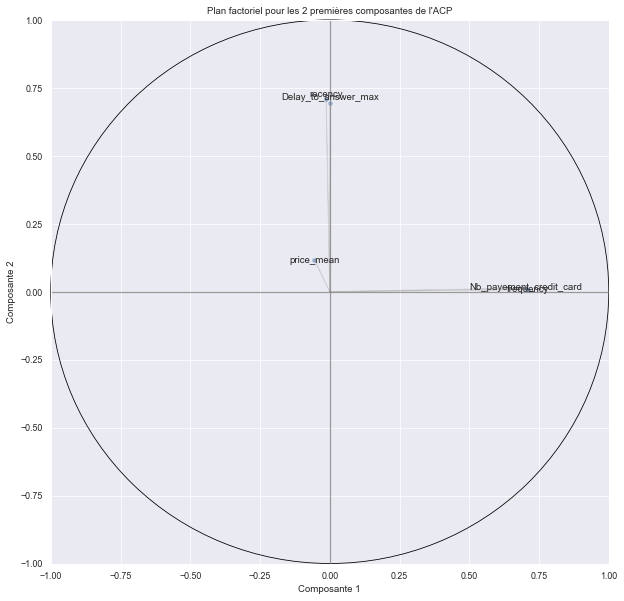

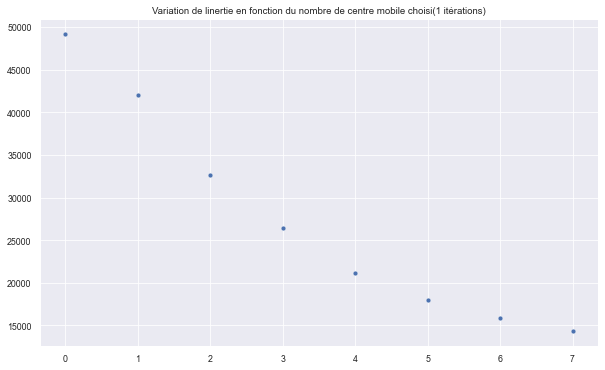

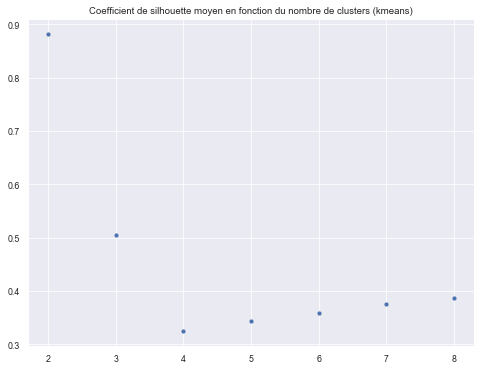

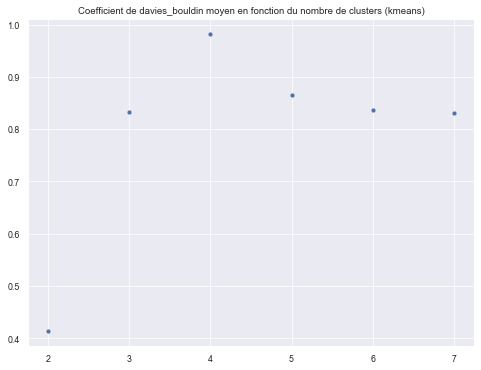

In [28]:
def rfm_plus(data1, data2):
    cols_to_add = data1[['Nb_payement_credit_card', 'Delay_to_answer_max', 'customer_unique_id']]
    data_rfm_plus = pd.merge(data2, cols_to_add,
                    how="left",
                    on='customer_unique_id')
    data_rfm_plus =  data_rfm_plus.sample(10000, random_state=1).copy().drop('customer_unique_id', axis = 1)
    numerics = ['int64', 'float64']

    X_rfm_plus = data_rfm_plus.select_dtypes(include=numerics)
    X_rfm_plus = preprocessing(X_rfm_plus)
    return X_rfm_plus
X_rfm_plus = rfm_plus(data1 = data_customers, data2 = data_rfm)
ACP(X = X_rfm_plus)
silhouettes(df = X_rfm_plus, Trial_nb = 1, max_clusters = 8)

# DBSCAN

In [30]:
dbs = DBSCAN(eps = 1, 
             min_samples=5,
               n_jobs=-1).fit(X_RFM.copy())

In [40]:
tsne = TSNE(n_components=2)
T = tsne.fit_transform(X_RFM.copy())

<AxesSubplot:title={'center':'Représentation de la séparation des données du DBSCAN via T-SNE'}>

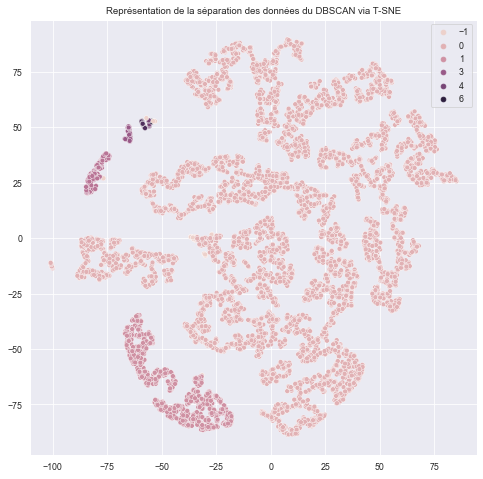

In [41]:
plt.figure(figsize=(8,8))
plt.title('Représentation de la séparation des données du DBSCAN via T-SNE')
sns.scatterplot(T[:,0], T[:,1], dbs.labels_)

In [42]:
nb_clusters_agg = 4

In [43]:
cah = AgglomerativeClustering(n_clusters = nb_clusters_agg
                             ).fit(X_RFM.copy())

In [45]:
#graph = pd.DataFrame(data = [T[:,0], T[:,1], dict_kmeans[(1,16)].labels_]).T
#graph.columns = ['X', 'Y', 'label_kmeans']